<a href="https://colab.research.google.com/github/joseph7104/-1INF46-Plan_Compras_Produccion/blob/master/notebooks/2-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
!git clone https://github.com/joseph7104/-1INF46-Plan_Compras_Produccion.git
%cd "./-1INF46-Plan_Compras_Produccion"

Cloning into '-1INF46-Plan_Compras_Produccion'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29 (delta 2), reused 24 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 3.32 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/-1INF46-Plan_Compras_Produccion


# **Config & imports**

In [63]:
# === Rutas del proyecto (relativas al repo) ===
RAW_DIR   = "data/raw"
PROC_DIR  = "data/processed"
FIG_DIR   = "reports/figures"
MET_DIR   = "reports/metrics"

import os, sys, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for d in [FIG_DIR, MET_DIR]:
    os.makedirs(d, exist_ok=True)

pd.set_option('display.max_columns', 200)
print("OK: rutas listas")


OK: rutas listas


# Carga dataset (con o sin features)**bold text**

In [64]:
daily_features = f"{PROC_DIR}/dataset_forecast_diario_features.csv"
daily_base     = f"{PROC_DIR}/dataset_forecast_diario.csv"

if os.path.exists(daily_features):
    df = pd.read_csv(daily_features, parse_dates=['fecha'])
    print("Cargado:", daily_features)
elif os.path.exists(daily_base):
    df = pd.read_csv(daily_base, parse_dates=['fecha'])
    print("Cargado:", daily_base)
else:
    raise FileNotFoundError("No encuentro dataset_forecast_diario(_features).csv en data/processed/")

print(df.shape)
df.head()


Cargado: data/processed/dataset_forecast_diario.csv
(10890, 45)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,evento_Ano_Nuevo,evento_Ninguno,evento_Dia_del_Amor_y_la_Amistad,evento_Jueves_Santo,evento_Viernes_Santo,evento_Dia_del_Trabajador,evento_Dia_de_la_Madre,evento_Batalla_de_Arica_/_Dia_de_la_Bandera,evento_Dia_del_Padre,evento_San_Pedro_y_San_Pablo,evento_Independencia_del_Peru,evento_Fiestas_Patrias,evento_Santa_Rosa_de_Lima,evento_Combate_de_Angamos,evento_Todos_los_Santos,evento_Inmaculada_Concepcion,evento_Navidad,evento_Fin_de_Ano,clima_Lluvioso,clima_Nublado,clima_Soleado,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2019-01-15,Arroz Chaufa,21,462.0,2019,1,15,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,34.0,25.0,35.0,NaN,32.857143,4.634241,29.642857,6.416411,NaN,NaN,0.781831,0.623490,0.0,1.0
1,2019-01-16,Arroz Chaufa,38,836.0,2019,1,16,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,21.0,35.0,16.0,NaN,32.285714,5.851333,28.642857,6.605442,NaN,NaN,0.974928,-0.222521,0.0,1.0
2,2019-01-17,Arroz Chaufa,32,704.0,2019,1,17,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,38.0,34.0,19.0,NaN,32.714286,6.183696,30.214286,5.950806,NaN,NaN,0.433884,-0.900969,0.0,1.0
3,2019-01-18,Arroz Chaufa,25,550.0,2019,1,18,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,32.0,36.0,30.0,NaN,32.428571,6.160550,31.142857,5.005491,NaN,NaN,-0.433884,-0.900969,0.0,1.0
4,2019-01-19,Arroz Chaufa,49,1078.0,2019,1,19,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,25.0,28.0,28.0,NaN,30.857143,6.491753,30.785714,5.264958,NaN,NaN,-0.974928,-0.222521,0.0,1.0


# **Chequeos rápidos (sanidad del dataset)**

In [65]:
print("Rango de fechas:", df['fecha'].min(), "→", df['fecha'].max())
print("Platos únicos:", df['plato'].nunique(), df['plato'].unique().tolist())
print("Nulos por columna (top):")
display(df.isna().mean().sort_values(ascending=False).head(15))

# cobertura por plato
cov = df.groupby('plato').agg(
    fechas=('fecha','nunique'),
    desde=('fecha','min'),
    hasta=('fecha','max'),
    total_filas=('plato','size'),
    total_cantidad=('cantidad','sum'),
    media_cantidad=('cantidad','mean')
).reset_index()
display(cov)


Rango de fechas: 2019-01-15 00:00:00 → 2024-12-31 00:00:00
Platos únicos: 5 ['Arroz Chaufa', 'Ceviche Clásico', 'Lomo Saltado', 'Pollo a la Brasa', 'Tallarines Verdes']
Nulos por columna (top):


,0
rolling_std_28,0.006428
rolling_mean_28,0.006428
lag_28,0.006428
plato,0.000000
fecha,0.000000
mes,0.000000
dia,0.000000
dow,0.000000
fin_de_semana,0.000000
feriado,0.000000


,plato,fechas,desde,hasta,total_filas,total_cantidad,media_cantidad
0,Arroz Chaufa,2178,2019-01-15,2024-12-31,2178,62027,28.478880
1,Ceviche Clásico,2178,2019-01-15,2024-12-31,2178,82621,37.934343
2,Lomo Saltado,2178,2019-01-15,2024-12-31,2178,124013,56.938935
3,Pollo a la Brasa,2178,2019-01-15,2024-12-31,2178,103619,47.575298
4,Tallarines Verdes,2178,2019-01-15,2024-12-31,2178,41315,18.969238


# **lags y rolling**

In [66]:
need_lags = not any(c.startswith('lag_') for c in df.columns)
need_roll = not any(c.startswith('rolling_') for c in df.columns)

if need_lags or need_roll:
    df = df.sort_values(['plato','fecha']).reset_index(drop=True)

    # Lags por plato
    if need_lags:
        for L in [1, 7, 14, 28]:
            df[f'lag_{L}'] = df.groupby('plato')['cantidad'].shift(L)

    # Rolling sin fuga de información (shift previo)
    if need_roll:
        def add_rolling(group, windows=(7,14,28)):
            s = group['cantidad'].shift(1)
            out = {}
            for w in windows:
                out[f'rolling_mean_{w}'] = s.rolling(w).mean()
                out[f'rolling_std_{w}']  = s.rolling(w).std()
            return pd.DataFrame(out, index=group.index)

        roll_feats = df.groupby('plato', group_keys=False).apply(add_rolling)
        df = pd.concat([df, roll_feats], axis=1)

    print("Se agregaron lags/rolling que faltaban.")

# codificación cíclica opcional (útil en modelos lineales)
if 'dow' in df.columns and 'mes' in df.columns:
    if not {'dow_sin','dow_cos'}.issubset(df.columns):
        df['dow_sin'] = np.sin(2*np.pi*df['dow']/7)
        df['dow_cos'] = np.cos(2*np.pi*df['dow']/7)
    if not {'mes_sin','mes_cos'}.issubset(df.columns):
        df['mes_sin'] = np.sin(2*np.pi*(df['mes']-1)/12)
        df['mes_cos'] = np.cos(2*np.pi*(df['mes']-1)/12)

print("Columnas ahora:", len(df.columns))


Columnas ahora: 45


# **EDA visual**

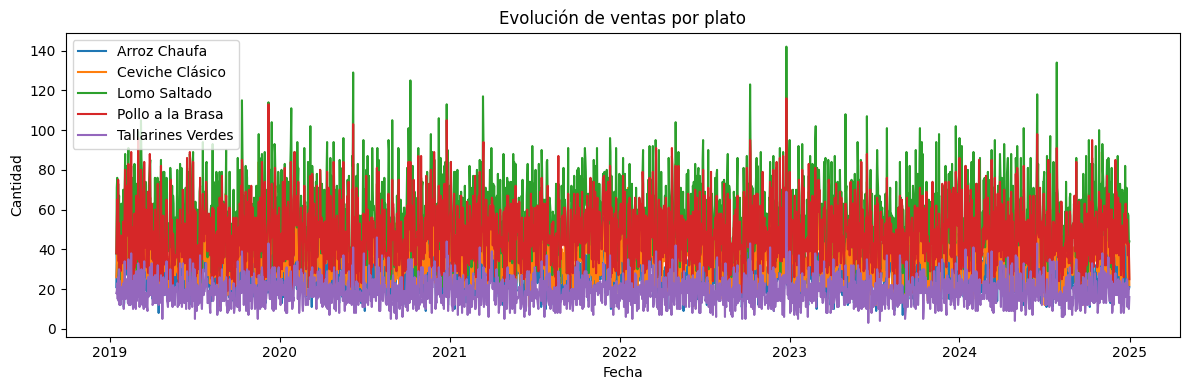

In [67]:
plt.figure(figsize=(12,4))
for i, plato in enumerate(df['plato'].unique(), start=1):
    temp = df[df['plato']==plato].sort_values('fecha')
    plt.plot(temp['fecha'], temp['cantidad'], label=plato)
plt.title('Evolución de ventas por plato')
plt.xlabel('Fecha'); plt.ylabel('Cantidad')
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/series_por_plato.png", dpi=120)
plt.show()


# **Boxplots por día de semana y mes**

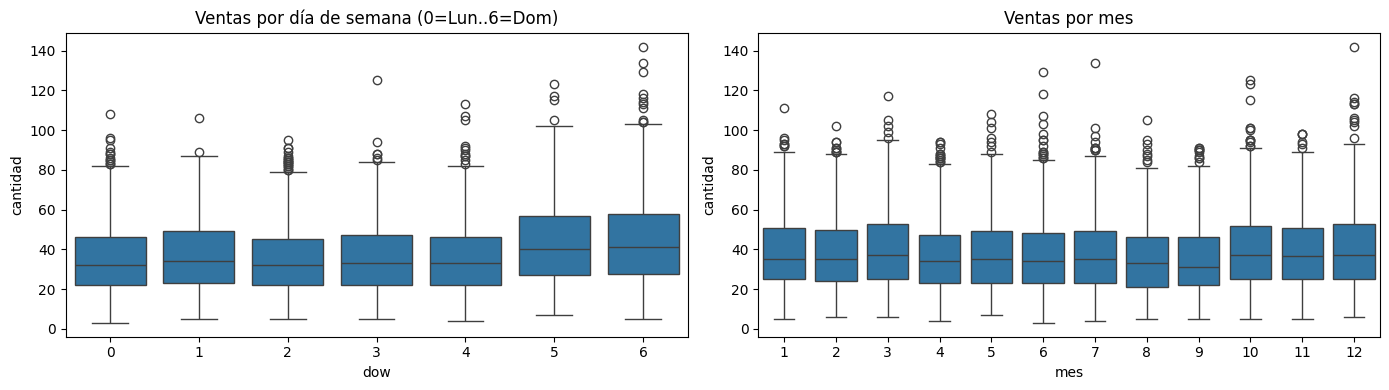

In [68]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.boxplot(data=df, x='dow', y='cantidad', ax=ax[0])
ax[0].set_title('Ventas por día de semana (0=Lun..6=Dom)')
sns.boxplot(data=df, x='mes', y='cantidad', ax=ax[1])
ax[1].set_title('Ventas por mes')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/boxplots_dow_mes.png", dpi=120)
plt.show()


# **Correlaciones**

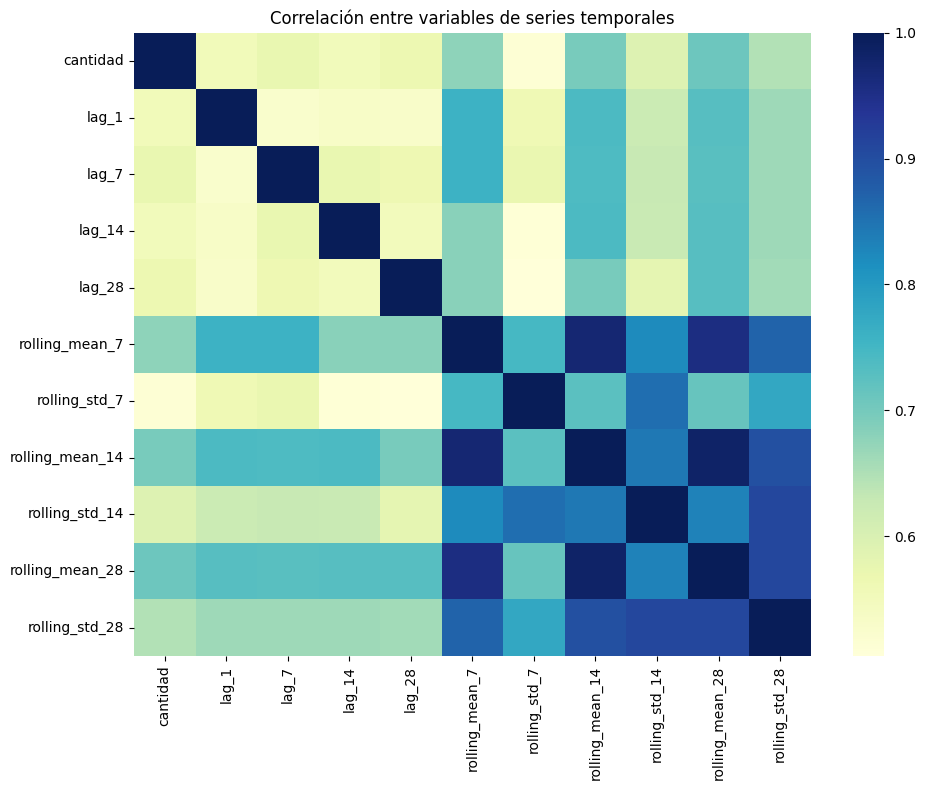

,cantidad
cantidad,1.000000
rolling_mean_28,0.709072
rolling_mean_14,0.697713
rolling_mean_7,0.678626
rolling_std_28,0.646854
rolling_std_14,0.592662
lag_7,0.573196
lag_28,0.566141
lag_1,0.553305
lag_14,0.551307


In [69]:
num_cols = ['cantidad'] + [c for c in df.columns if c.startswith('lag_') or c.startswith('rolling_')]
corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='YlGnBu', annot=False)
plt.title('Correlación entre variables de series temporales')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/corr_lags_rolling.png", dpi=120)
plt.show()

corr['cantidad'].sort_values(ascending=False).head(12)


# **Baselines**

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

res_baselines = []

for plato in df['plato'].unique():
    d = df[df['plato'] == plato].sort_values('fecha').reset_index(drop=True)

    # --- crear features de baseline ANTES del split ---
    # baseline 1: naive (lag_7); si no existe en df, créalo aquí
    if 'lag_7' not in d.columns:
        d['lag_7'] = d['cantidad'].shift(7)

    # baseline 2: media móvil 7 SIN fuga (shift(1) antes del rolling)
    d['mm7'] = d['cantidad'].shift(1).rolling(7).mean()

    # --- split temporal 80/20 (después de tener columnas listas) ---
    n = len(d)
    split = int(n * 0.8)
    d_train, d_test = d.iloc[:split].copy(), d.iloc[split:].copy()

    # Targets
    y_true = d_test['cantidad'].values

    # Pred 1: naive lag-7 (si hay NaN en el arranque, rellenamos con la media de train)
    y_hat_naive = d_test['lag_7'].fillna(d_train['cantidad'].mean()).values
    mae_n, rmse_n = metrics(y_true, y_hat_naive)

    # Pred 2: media móvil 7 (relleno igual por seguridad)
    y_hat_mm7 = d_test['mm7'].fillna(d_train['cantidad'].mean()).values
    mae_m, rmse_m = metrics(y_true, y_hat_mm7)

    res_baselines.append([plato, mae_n, rmse_n, mae_m, rmse_m])

res_b = pd.DataFrame(res_baselines,
                     columns=['plato','MAE_naive7','RMSE_naive7','MAE_mm7','RMSE_mm7'])
display(res_b)

out_metrics = f"{MET_DIR}/baseline_metrics.csv"
res_b.to_csv(out_metrics, index=False)
print("✅ Baselines guardados en:", out_metrics)


,plato,MAE_naive7,RMSE_naive7,MAE_mm7,RMSE_mm7
0,Arroz Chaufa,10.330275,12.805711,8.305701,10.273454
1,Ceviche Clásico,13.674312,16.925769,10.868611,13.687489
2,Lomo Saltado,18.633028,23.483549,15.142202,18.773323
3,Pollo a la Brasa,15.672018,19.728838,12.611730,15.709425
4,Tallarines Verdes,7.302752,9.250837,6.034404,7.459379


✅ Baselines guardados en: reports/metrics/baseline_metrics.csv


# **Limpieza final para modelar**

In [71]:
# Quitar la dummy base si existe para evitar colinealidad
drop_cols = [c for c in df.columns if c == 'evento_Ninguno']
df_model = df.drop(columns=drop_cols, errors='ignore').copy()

# Columnas mínimas para entrenar: lags y rolling que realmente EXISTAN
min_required = [c for c in df_model.columns if c.startswith('lag_') or c.startswith('rolling_')]

# (opcional) si por alguna razón quieres también mm7 como feature, solo si existe:
# if 'mm7' in df_model.columns:
#     min_required.append('mm7')

# filtra NaN solo en las columnas que existan
cols_for_dropna = [c for c in min_required if c in df_model.columns]
if cols_for_dropna:
    df_model = df_model.dropna(subset=cols_for_dropna).reset_index(drop=True)

print("Rows totales:", len(df), "→ para modelar:", len(df_model))

out_model = f"{PROC_DIR}/dataset_forecast_diario_features.csv"
df_model.to_csv(out_model, index=False)
print("✅ Dataset final para modelos guardado en:", out_model)
df_model.head()


Rows totales: 10890 → para modelar: 10820
✅ Dataset final para modelos guardado en: data/processed/dataset_forecast_diario_features.csv


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,evento_Ano_Nuevo,evento_Dia_del_Amor_y_la_Amistad,evento_Jueves_Santo,evento_Viernes_Santo,evento_Dia_del_Trabajador,evento_Dia_de_la_Madre,evento_Batalla_de_Arica_/_Dia_de_la_Bandera,evento_Dia_del_Padre,evento_San_Pedro_y_San_Pablo,evento_Independencia_del_Peru,evento_Fiestas_Patrias,evento_Santa_Rosa_de_Lima,evento_Combate_de_Angamos,evento_Todos_los_Santos,evento_Inmaculada_Concepcion,evento_Navidad,evento_Fin_de_Ano,clima_Lluvioso,clima_Nublado,clima_Soleado,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2019-01-29,Arroz Chaufa,23,506.0,2019,1,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,16.0,18.0,21.0,35.0,23.142857,7.197883,27.857143,10.668841,28.750000,8.686409,0.781831,0.623490,0.0,1.000000
1,2019-01-30,Arroz Chaufa,39,858.0,2019,1,30,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,23.0,27.0,38.0,16.0,23.857143,6.841749,28.000000,10.583005,28.321429,8.662621,0.974928,-0.222521,0.0,1.000000
2,2019-01-31,Arroz Chaufa,11,242.0,2019,1,31,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,39.0,15.0,32.0,19.0,25.571429,8.941610,28.071429,10.658794,29.142857,8.540597,0.433884,-0.900969,0.0,1.000000
3,2019-02-01,Arroz Chaufa,13,286.0,2019,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,11.0,34.0,25.0,30.0,25.000000,9.814955,26.571429,11.507284,28.857143,9.013218,-0.433884,-0.900969,0.5,0.866025
4,2019-02-02,Arroz Chaufa,30,660.0,2019,2,2,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,13.0,23.0,49.0,28.0,22.000000,9.814955,25.714286,12.066665,28.250000,9.493175,-0.974928,-0.222521,0.5,0.866025


In [74]:
# ======================================================================
# PASO 0: CONFIGURAR GIT (Por si el entorno se reinició)
# ======================================================================
!git config --global user.email "joseph7104@gmail.com"
!git config --global user.name "joseph7104"

# ======================================================================
# PASO 1: AÑADIR LOS ARCHIVOS "UNTRACKED"
# Este es el comando clave que faltaba por ejecutarse correctamente.
# Le dice a Git que rastree estos archivos.
# ======================================================================
!git add data/processed/dataset_forecast_diario_features.csv reports/figures/*.png reports/metrics/baseline_metrics.csv

# ======================================================================
# PASO 2: CREAR EL COMMIT
# Ahora que los archivos están añadidos, el commit funcionará.
# ======================================================================
!git commit -m "Añadir resultados de EDA, features y métricas baseline"

# ======================================================================
# PASO 3: SUBIR A GITHUB (PUSH)
# Este código ya lo tenías bien.
# ======================================================================
from google.colab import userdata

# --- ¡CONFIGURA ESTO! ---
username = "joseph7104"
repository = "-1INF46-Plan_Compras_Produccion" # Ya está bien configurado
# -------------------------

try:
    token = userdata.get('GH_TOKEN')
except userdata.SecretNotFoundError:
    print("Error: El 'secret' con nombre 'GH_TOKEN' no se encontró.")
    raise

repo_url_with_token = f"https://{token}@github.com/{username}/{repository}.git"
!git remote set-url origin {repo_url_with_token}

print("\nSubiendo cambios a GitHub...")
!git push origin master

[master a430e24] Añadir resultados de EDA, features y métricas baseline
 5 files changed, 10827 insertions(+)
 create mode 100644 data/processed/dataset_forecast_diario_features.csv
 create mode 100644 reports/figures/boxplots_dow_mes.png
 create mode 100644 reports/figures/corr_lags_rolling.png
 create mode 100644 reports/figures/series_por_plato.png
 create mode 100644 reports/metrics/baseline_metrics.csv

Subiendo cambios a GitHub...
Enumerating objects: 18, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 2 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 868.96 KiB | 5.46 MiB/s, done.
Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/joseph7104/-1INF46-Plan_Compras_Produccion.git
   574a130..a430e24  master -> master
